In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2hsv

In [2]:
#load the dataset subset
def load_images_from_folder(folder, limit=8):
    images = []
    for idx, filename in enumerate(os.listdir(folder)):
        if idx >= limit:
            break
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return images

def plot_images_in_grid(images, title):
    plt.figure(figsize=(12, 10))
    for i, img in enumerate(images, 1):
        plt.subplot(2, 4, i)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

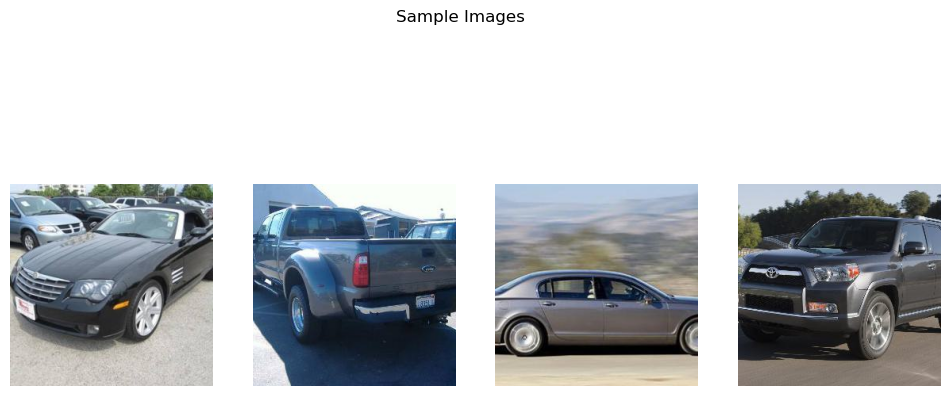

In [3]:
#viz train images 
train_images = load_images_from_folder('../../../Images/single class samples/No Blur/')
plot_images_in_grid(train_images, 'Sample Images')

In [4]:
#convert to hsv from rgb
def convert_rgb_to_hsv_and_visualize(images, title):
    hsv_images = []
    for img in images:
        hsv = rgb2hsv(img)
        hsv_images.append(hsv)

    plot_images_in_grid(hsv_images, title)
    return hsv_images

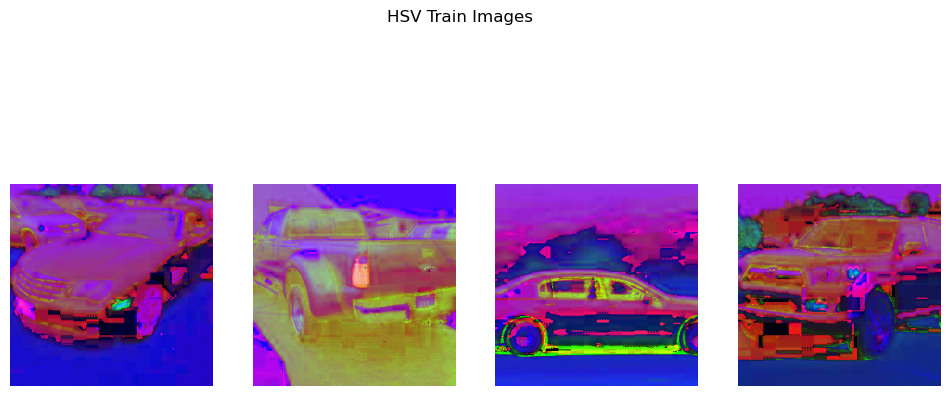

In [5]:
hsv_train_images = convert_rgb_to_hsv_and_visualize(train_images, 'HSV Train Images')

In [6]:
def compute_hsv_histograms(hsv_images):
    histograms = []
    for hsv in hsv_images:
        #hist for each channel
        hist_hue = np.histogram(hsv[:,:,0], bins=256, range=(0, 1))
        hist_saturation = np.histogram(hsv[:,:,1], bins=256, range=(0, 1))
        hist_value = np.histogram(hsv[:,:,2], bins=256, range=(0, 1))
        
        histograms.append((hist_hue, hist_saturation, hist_value))
    return histograms

In [7]:
histograms_train = compute_hsv_histograms(hsv_train_images)

In [8]:
def plot_hsv_histogram(histograms, images, title):
    plt.figure(figsize=(12, 8))
    for i, ((hist_hue, hist_saturation, hist_value), img) in enumerate(zip(histograms, images), 1):
        plt.subplot(2, 4, i)
        plt.plot(hist_hue[1][:-1], hist_hue[0], color='r', label='Hue')
        plt.plot(hist_saturation[1][:-1], hist_saturation[0], color='g', label='Saturation')
        plt.plot(hist_value[1][:-1], hist_value[0], color='b', label='Value')
        plt.title(f'Image {i}')
        plt.legend()
    plt.suptitle(title)
    plt.show()

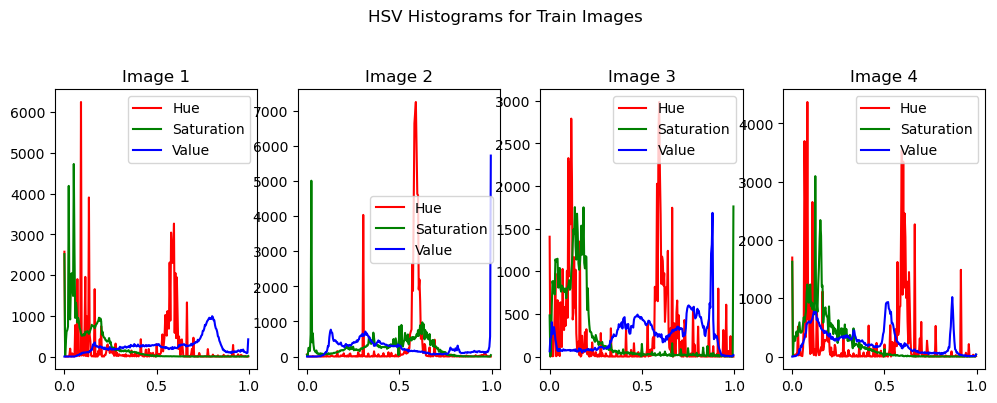

In [9]:
plot_hsv_histogram(histograms_train, train_images, 'HSV Histograms for Train Images')

## Class separability and HSV Histogram

In [10]:
def load_and_classify_images(folders):
    class_images = {'Convertible': [],'SUV': [], 'Sedan': []}
    
    for folder in folders:
        for filename in os.listdir(folder):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                for car_class in class_images.keys():
                    if car_class in filename:
                        class_images[car_class].append(img_rgb)
                        break

    return class_images

folders = ['train', 'test']
class_images = load_and_classify_images(folders)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\ijyli\anaconda3\envs\computervision\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ijyli\AppData\Local\Temp\ipykernel_19360\2277014887.py", line 17, in <module>
    class_images = load_and_classify_images(folders)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ijyli\AppData\Local\Temp\ipykernel_19360\2277014887.py", line 5, in load_and_classify_images
    for filename in os.listdir(folder):
                    ^^^^^^^^^^^^^^^^^^
FileNotFoundError: [WinError 3] The system cannot find the path specified: 'train'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\ijyli\anaconda3\envs\computervision\Lib\site-packages\IPython\core\interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^

In [ ]:
#hist for each class
def compute_hsv_histogram(image, bins=30):
    hsv_image = rgb2hsv(image)
    hist_hue = np.histogram(hsv_image[:, :, 0].flatten(), bins=bins, range=(0, 1))
    hist_saturation = np.histogram(hsv_image[:, :, 1].flatten(), bins=bins, range=(0, 1))
    hist_value = np.histogram(hsv_image[:, :, 2].flatten(), bins=bins, range=(0, 1))
    return hist_hue[0], hist_saturation[0], hist_value[0]

def compute_class_histograms(class_images, bins=30):
    class_histograms = {}
    for car_class, images in class_images.items():
        histograms = [compute_hsv_histogram(img, bins) for img in images]
        class_histograms[car_class] = histograms
    return class_histograms

class_histograms = compute_class_histograms(class_images)

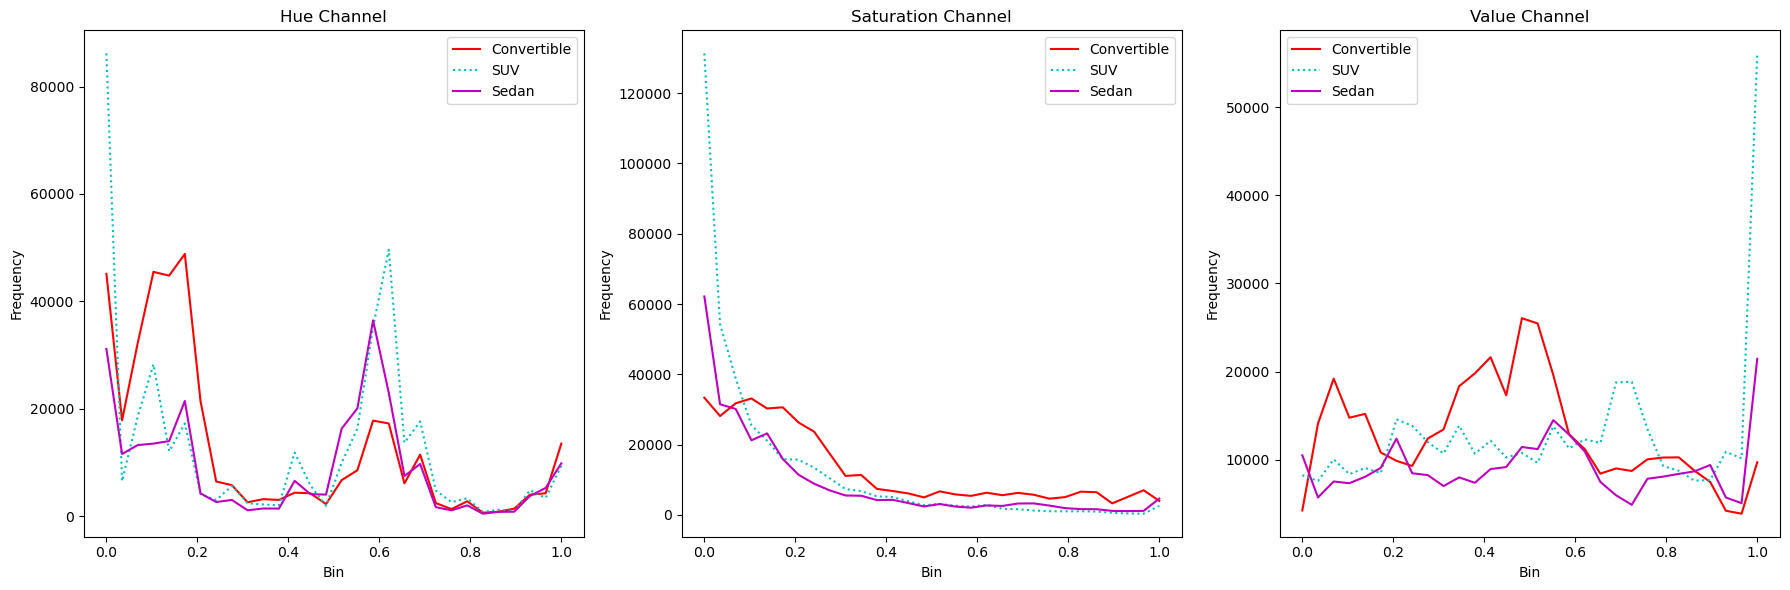

In [ ]:
def plot_class_histograms(class_histograms, bins=30):
    plt.figure(figsize=(18, 6))
    class_styles = {
        'Convertible': ('r', '-'),
        'Coupe': ('g', '--'),
        'Pickup': ('b', '-.'),
        'SUV': ('c', ':'),
        'Sedan': ('m', '-')
    }
    labels = ['Hue', 'Saturation', 'Value']

    for i, label in enumerate(labels):
        plt.subplot(1, 3, i + 1)
        for car_class, histograms in class_histograms.items():
            avg_hist = np.mean([histogram[i] for histogram in histograms], axis=0)
            color, linestyle = class_styles[car_class]
            plt.plot(np.linspace(0, 1, bins), avg_hist, label=car_class, color=color, linestyle=linestyle)
            plt.title(f'{label} Channel')
            plt.xlabel('Bin')
            plt.ylabel('Frequency')
            plt.legend()

    plt.tight_layout()
    plt.show()

plot_class_histograms(class_histograms)

### Inferences 

#### Hue Channel - 
- peak in the Convertible in the lower end of the hue spectrum , whihc kin dof indicates a prevalence of colors like red or pinks that are typically aossciated with "sportier vehicles"
- SUVs seems to have relatively higher freq which might suggest that these vehicles are often have darker colors
- Sedans have a moderate frequency across the value spectrum (with no prominent peaks) indicating a balanced mix of bright and dark images

#### Saturation Channel - 
- Convertibles seem to have a higher saturation value (with a sharper decline) which gives the idea that these cars often come in brighter and more vivid colors
- SUVs and Sedans show similar patterns in saturation with SUVs having a slightly higher frequency across the saturation spectrum indicating more intense colors compared to Sedans

#### Value Channel - 
- Convertibles have multiple peak which seem to suggest variability in the brightness of the images potentially indicating differences in the "finish" of the cars
- SUVs seem to have a relatively high frequency which might suggest that these vehicles have darker colors
- Sedans have a moderate frequency across the value spectrum (with no prominent peaks) indicating a balanced mix of bright and dark images